The following cell holds the definition of our parameters, these values can be overriden by rendering the with e.g. the following command:

papermill -p alpha 0.2 -p ratio 0.3 universe_analysis.ipynb output/test_run.ipynb

In [1]:
run_no = 0
universe_id = "test"
universe = {
    #"scale": "scale", # "scale", "do-not-scale",
    #"encode_categorical": "one-hot", # "ordinal", "one-hot"
    "model": "elasticnet", # "logreg", "penalized_logreg", "rf", "gbm", "elasticnet"
    "cutoff": ["quantile_0.15", "quantile_0.30"],
    "exclude_features": "nationality-sex", # "none", "nationality", "sex", "nationality-sex"
    "exclude_subgroups": "keep-all", # "keep-all", "drop-non-german"
    "eval_fairness_grouping": ["majority-minority", "nationality-all"]
}

output_dir="./output"
seed=0

In [2]:
import json
# Parse universe into dict if it is passed as a string
if isinstance(universe, str):
    universe = json.loads(universe)

In [3]:
# Auto-reload the custom package
%load_ext autoreload
%autoreload 1
%aimport fairness_multiverse

In [4]:
from fairness_multiverse.universe import UniverseAnalysis

universe_analysis = UniverseAnalysis(
    run_no = run_no,
    universe_id = universe_id,
    universe = universe,
    output_dir=output_dir,
)

In [5]:
import numpy as np
parsed_seed = int(seed)
np.random.seed(parsed_seed)
print(f"Using Seed: {parsed_seed}")

Using Seed: 0


# Loading Data

Load siab_train, siab_test, siab_calib and/or 
load siab_train_features, siab_train_labels

In [ ]:
# Do I need to load siab?

from pathlib import Path
import pandas as pd

# File paths
raw_file = Path("data/raw/siab.csv")
cache_file = Path("data/siab_cached.csv.gz")

# Ensure cache directory exists
cache_file.parent.mkdir(parents=True, exist_ok=True)

# Load with simple caching
if cache_file.exists():
    print(f"Loading SIAB data from cache: {cache_file}")
    siab = pd.read_csv(cache_file, compression='gzip')
else:
    print(f"Cache not found. Reading raw SIAB data: {raw_file}")
    siab = pd.read_csv(raw_file)
    siab.to_csv(cache_file, index=False, compression='gzip')
    print(f"Cached SIAB data to: {cache_file}")

# Now use `siab` DataFrame as needed
print(siab.shape)


In [6]:
import pandas as pd

X_train = pd.read_csv("./data/X_train.csv")
y_train = pd.read_csv("./data/y_train.csv")

In [7]:
X_test = pd.read_csv("./data/X_test.csv")
y_true = pd.read_csv("./data/y_test.csv")

In [8]:
# Auxiliary data needed downstream in the pipeline

#X_test, y_test 

org_train = X_train.copy()
org_test = X_test.copy()

In [ ]:
siab

Pre-Processing for Selected Task -> skipped. I think I don't need this

# Preprocessing Data

In [9]:
# EXCLUDE PROTECTED FEATURES
# ----------------------
# "exclude_features": "none", # "nationality", "sex", "nationality-sex"

excluded_features = universe["exclude_features"].split("-") # split, e.g.: "nationality-sex" -> ["nationality", "sex"]
excluded_features_dictionary = {
    "nationality": ["maxdeutsch1", "maxdeutsch.Missing."],
    "sex": ["frau1"],
}


In [10]:
# Code nice names to column names

excluded_features_columns = [
    excluded_features_dictionary[f] for f in excluded_features if len(f) > 0 and f != "none"
]

In [11]:
from utils import flatten_once

excluded_features_columns = flatten_once(excluded_features_columns)

In [12]:
if len(excluded_features_columns) > 0:
    print(f"Dropping features: {excluded_features_columns}")
    X_train.drop(excluded_features_columns, axis=1, inplace=True)

Dropping features: ['maxdeutsch1', 'maxdeutsch.Missing.', 'frau1']


In [13]:
if len(excluded_features_columns) > 0:
    print(f"Dropping features: {excluded_features_columns}")
    X_test.drop(excluded_features_columns, axis=1, inplace=True)

Dropping features: ['maxdeutsch1', 'maxdeutsch.Missing.', 'frau1']


In [14]:
# EXCLUDE CERTAIN SUBGROUPS
# ----------------------

mode = universe.get("exclude_subgroups", "keep-all") 
# Fetches the exclude_subgroups setting from the universe dict.
# Defaults to "keep-all" if the key is missing.

In [15]:
if mode == "keep-all":
    keep_mask = pd.Series(True, index=org_train.index)

# org_train contains the original feature columns from features_org (in Simson)
# features_org contains unprocessed features, for me X_train at beginning ???
# For keep-all, creates a boolean Series (keep_mask) of all True, so no rows are removed.

elif mode == "drop-non-german":
    keep_mask = org_train["maxdeutsch1"] == 1 # ??? what about missing values?

else:
    raise ValueError(f"Unsupported mode for exclude_subgroups: {mode}")


In [16]:
n_drop = (~keep_mask).sum() # Calculates how many rows are set to be dropped
if n_drop > 0:
    pct = n_drop / len(keep_mask) * 100
    print(f"Dropping {n_drop} rows ({pct:.2f}%) where mode='{mode}'")

In [17]:
X_train = X_train[keep_mask]

In [18]:
y_train = y_train[keep_mask]

# Model Training

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

if (universe["model"] == "logreg"):
    model = LogisticRegression(penalty=None, solver="newton-cg", max_iter=1000) # include random_state=19 ?
elif (universe["model"] == "penalized_logreg"):
    model = LogisticRegression(penalty="l2", C=1.0, solver="newton-cg", max_iter=1000)
elif (universe["model"] == "rf"):
    model = RandomForestClassifier(n_estimators=100, n_jobs=-1)
elif (universe["model"] == "gbm"):
    model = GradientBoostingClassifier()
elif (universe["model"] == "elasticnet"):
    model = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5) # which solver to use?
else:
    raise "Unsupported universe.model"

In [20]:
from fairness_multiverse.universe import predict_w_threshold

In [21]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

model = Pipeline([
    #("continuous_processor", continuous_processor),
    #("categorical_preprocessor", categorical_preprocessor),
    #("scale", StandardScaler() if universe["scale"] == "scale" else None),
    ("model", model),
])

In [22]:
model.fit(X_train, y_train.values.ravel())

/Users/julia/.local/share/virtualenvs/fairml-multiverse-emco0tgS/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,steps,"[('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None


In [23]:
y_prob = model.predict_proba(X_test)
y_pred_default = predict_w_threshold(y_prob, 0.7)

# Naive prediction
accuracy_score(y_true = y_true, y_pred = y_pred_default)

0.8714747519785977

In [24]:
model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

# Conformal Prediction

# (Fairness) Metrics

In [25]:
# do I need to include maxdeutsch1.missing?

import numpy as np

colname_to_bin = "maxdeutsch1"
majority_value = org_train[colname_to_bin].mode()[0]

org_test["majmin"] = np.where(org_test[colname_to_bin] == majority_value, "majority", "minority")

In [26]:
example_universe = universe.copy()
example_universe["cutoff"] = example_universe["cutoff"][0]
example_universe["eval_fairness_grouping"] = example_universe["eval_fairness_grouping"][0]
fairness_dict, metric_frame = universe_analysis.compute_metrics(
    example_universe,
    y_pred_prob=y_prob,
    y_test=y_true,
    org_test=org_test,
)

# Overall

Fairness
Main fairness target: Equalized Odds. Seems to be a better fit than equal opportunity, since we're not only interested in Y = 1. Seems to be a better fit than demographic parity, since we also care about accuracy, not just equal distribution of preds.

Pick column for computation of fairness metrics

Performance
Overall performance measures, most interesting in relation to the measures split by group below

In [27]:
metric_frame.overall

accuracy                   0.259068
balanced accuracy          0.543076
f1                         0.242613
precision                  0.139614
false positive rate        0.838943
false negative rate        0.074904
selection rate             0.849994
count                  89710.000000
dtype: float64

By Group

In [28]:
metric_frame.by_group

,accuracy,balanced accuracy,f1,precision,false positive rate,false negative rate,selection rate,count
majmin,,,,,,,,
majority,0.289316,0.553918,0.253576,0.147220,0.805730,0.086433,0.819980,69170.0
minority,0.157205,0.510469,0.209652,0.117533,0.948657,0.030405,0.951071,20540.0


array([[<Axes: title={'center': 'accuracy'}, xlabel='majmin'>,
        <Axes: title={'center': 'balanced accuracy'}, xlabel='majmin'>,
        <Axes: title={'center': 'f1'}, xlabel='majmin'>],
       [<Axes: title={'center': 'precision'}, xlabel='majmin'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='majmin'>,
        <Axes: title={'center': 'false negative rate'}, xlabel='majmin'>],
       [<Axes: title={'center': 'selection rate'}, xlabel='majmin'>,
        <Axes: title={'center': 'count'}, xlabel='majmin'>,
        <Axes: xlabel='majmin'>]], dtype=object)

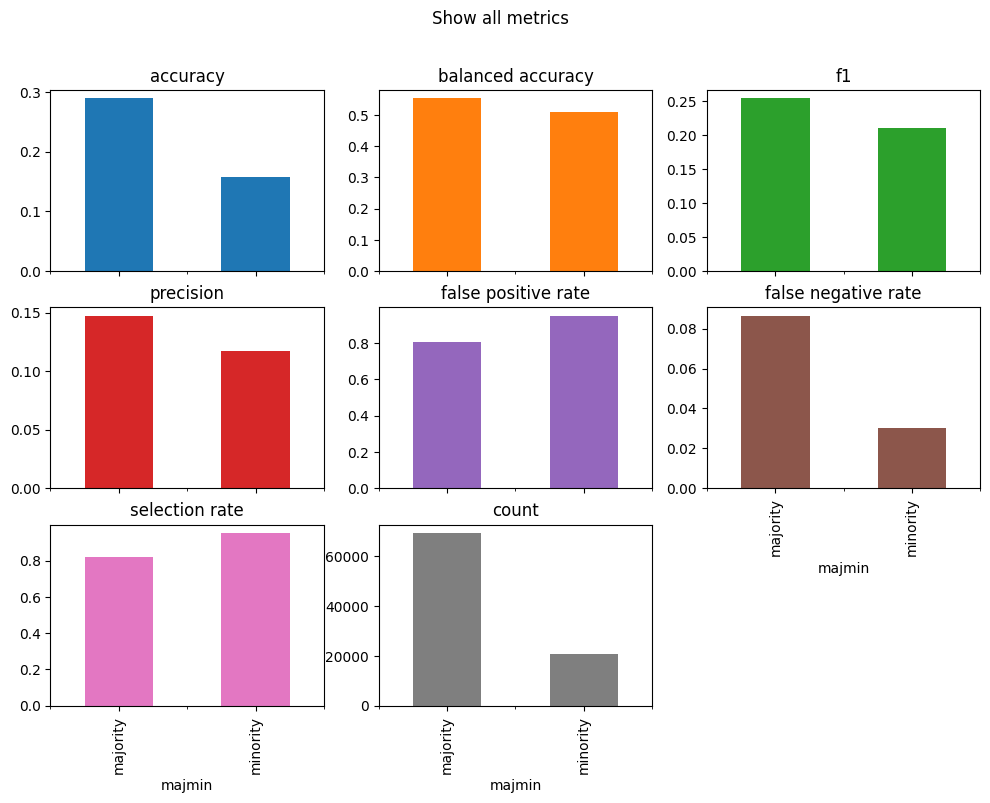

In [29]:
# In a graphic
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

# Final Output

In [30]:
sub_universes = universe_analysis.generate_sub_universes()
len(sub_universes)

4

In [31]:
def filter_sub_universe_data(sub_universe, org_test):
    # Keep all rows — no filtering
    keep_rows_mask = np.ones(org_test.shape[0], dtype=bool)

    print(f"[INFO] Keeping all rows: {keep_rows_mask.sum()} rows retained.")
    return keep_rows_mask

In [32]:
final_output = universe_analysis.generate_final_output(
    y_pred_prob=y_prob,
    y_test=y_true,
    org_test=org_test,
    save=True,
    filter_data=filter_sub_universe_data
)
final_output

Stopping execution_time clock.
[INFO] Keeping all rows: 89710 rows retained.
[INFO] Keeping all rows: 89710 rows retained.
[INFO] Keeping all rows: 89710 rows retained.
[INFO] Keeping all rows: 89710 rows retained.


,run_no,universe_id,universe_settings,execution_time,test_size_n,test_size_frac,fair_main_equalized_odds_difference,fair_main_equalized_odds_ratio,fair_main_demographic_parity_difference,fair_main_demographic_parity_ratio,...,perf_grp_precision_0,perf_grp_precision_1,perf_grp_false positive rate_0,perf_grp_false positive rate_1,perf_grp_false negative rate_0,perf_grp_false negative rate_1,perf_grp_selection rate_0,perf_grp_selection rate_1,perf_grp_count_0,perf_grp_count_1
0,0,test,"{""cutoff"": ""quantile_0.15"", ""eval_fairness_gro...",83.702096,89710,1.0,0.142927,0.849338,0.131091,0.862165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,test,"{""cutoff"": ""quantile_0.15"", ""eval_fairness_gro...",83.702096,89710,1.0,0.142927,0.849338,0.131091,0.862165,...,0.117533,0.147220,0.948657,0.805730,0.030405,0.086433,0.951071,0.819980,20540.0,69170.0
0,0,test,"{""cutoff"": ""quantile_0.30"", ""eval_fairness_gro...",83.702096,89710,1.0,0.270057,0.696075,0.250739,0.719321,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,0,test,"{""cutoff"": ""quantile_0.30"", ""eval_fairness_gro...",83.702096,89710,1.0,0.270057,0.696075,0.250739,0.719321,...,0.120007,0.164664,0.888565,0.618507,0.070101,0.199234,0.893330,0.642591,20540.0,69170.0
